In [1]:
!nvidia-smi

Sat Mar 23 03:56:03 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.39       Driver Version: 418.39       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    12W /  70W |    109MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [5]:
import gc
from os.path import join as pjoin
import os
from datetime import datetime

In [6]:
from fastai.vision import ImageDataBunch,ImageList,get_transforms,models,cnn_learner,accuracy
import torch

## Prepare for loging

In [7]:
import json
import os.path
import re
import ipykernel
import requests


from requests.compat import urljoin

from notebook.notebookapp import list_running_servers


def get_notebook_name():
    """
    Return the full path of the jupyter notebook.
    """
    kernel_id = re.search('kernel-(.*).json',
                          ipykernel.connect.get_connection_file()).group(1)
    servers = list_running_servers()
    for ss in servers:
        response = requests.get(urljoin(ss['url'], 'api/sessions'),
                                params={'token': ss.get('token', '')})
        for nn in json.loads(response.text):
            if nn['kernel']['id'] == kernel_id:
                relative_path = nn['notebook']['path']
                return relative_path
            




In [8]:
# vars for models logging

TRAIN_LOG_DIR = 'train_log'
MODEL_NAME = get_notebook_name().split('.')[0]

os.makedirs(pjoin(TRAIN_LOG_DIR,MODEL_NAME),exist_ok=True)

find_version = lambda x : int(x.split('.')[0])
list_versions = sorted(list(map(find_version,os.listdir(pjoin(TRAIN_LOG_DIR,MODEL_NAME)))))
version = list_versions[-1] + 1 if len(list_versions)>0 else 0

date = datetime.today().strftime('%d-%m-%Y-%H-%M')
model_save_dir = pjoin(TRAIN_LOG_DIR,MODEL_NAME,
                       f"{version:0>3d}" +'.'+date)
os.makedirs(model_save_dir,exist_ok=True)
model_save_dir


'train_log/resnet34-fastai/000.23-03-2019-05-45'

In [10]:
print(f"""
Note for version {version} model {MODEL_NAME}:
- First time
""")


Note for version 0 model resnet34-fastai:
- First time



### Init data loader

In [11]:
data_path = '/home/qnkhuat/data/emotion_compilation_split'
tfms = get_transforms(do_flip=True,
                      flip_vert=False,
                      max_rotate=10,
                      max_zoom=1.1,
                     )
# ran this get erro in THcroe
data = (ImageDataBunch.from_folder(data_path,test='test',size=48,ds_tfms=tfms,bs=256)
       .normalize())

In [ ]:
data.show_batch(rows=3)

## Init model

In [12]:
model = models.resnet34

In [13]:
learn = cnn_learner(data, model)

In [14]:
learn.model_dir = os.path.abspath(model_save_dir)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


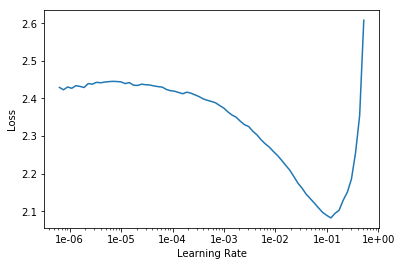

In [15]:
learn.lr_find()
learn.recorder.plot()

In [16]:
lr=5e-2

In [17]:
learn.metrics = [accuracy]

## Start training

In [18]:
learn.fit_one_cycle(12,slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.587889,1.402360,0.483685,00:30
1,1.374342,1.177295,0.587897,00:30
2,1.178996,1.100357,0.611614,00:32
3,1.063956,1.067023,0.616645,00:29
4,0.994025,0.881510,0.671266,00:31
5,0.954284,0.834445,0.704039,00:31
6,0.890366,0.794269,0.717407,00:23
7,0.859784,0.772761,0.726606,00:15
8,0.814366,0.755652,0.729337,00:17
9,0.791981,0.728708,0.737962,00:15


In [19]:
#learn.fit(12,lr)

In [20]:
learn.save('74.6_before_unfreeze')

#### Unfreeze 

In [21]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


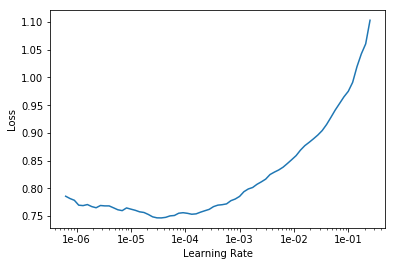

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
lr = 2e-5

In [ ]:
learn.fit_one_cycle(20,slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.739128,0.711446,0.746299,00:32
1,0.734834,0.710021,0.746730,00:29
2,0.736050,0.707156,0.748742,00:30
3,0.739777,0.705003,0.746874,00:31
4,0.736654,0.702474,0.746730,00:29
5,0.730259,0.699444,0.747161,00:29
6,0.721606,0.695909,0.750036,00:31
7,0.715758,0.691904,0.751761,00:30
8,0.714261,0.689849,0.752336,00:33
9,0.707732,0.688133,0.752911,00:31


In [ ]:
learn.fit(50,lr=10e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.631624,0.620317,0.772603,00:14
1,0.627095,0.621197,0.776053,00:14
2,0.622918,0.610809,0.779071,00:16
3,0.612277,0.637281,0.758373,00:15
4,0.615344,0.600674,0.780509,00:14
5,0.610439,0.599617,0.780078,00:14
6,0.609335,0.597908,0.783384,00:14
7,0.593355,0.616356,0.776484,00:15
8,0.591791,0.613835,0.779071,00:16
9,0.587021,0.598441,0.783096,00:14


#### Refreeze

In [ ]:
learn.freeze()

In [ ]:
learn.fit_one_cycle(12)

In [ ]:
learn.fit(30,lr=10e-6)

In [65]:
learn.save('resnet18_22_3_10_79.6.pth')

In [55]:
#learn.fit(10,lr=10e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.721224,0.696522,0.755067,00:15
1,0.669220,0.751952,0.721432,00:15
2,0.652717,0.666329,0.749030,00:17
3,0.618793,0.629089,0.776484,00:16
4,0.596754,0.614895,0.782521,00:16
5,0.586281,0.605672,0.775765,00:17
6,0.563803,0.611629,0.778640,00:17
7,0.551235,0.626276,0.771022,00:16
8,0.524861,0.688259,0.760098,00:16
9,0.510898,0.607218,0.778784,00:16


In [22]:
learn.freeze()

In [23]:
learn.fit(3,lr=10e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.573903,0.585458,0.788127,00:15
1,0.572768,0.584008,0.787696,00:16
2,0.565022,0.584421,0.787552,00:16


In [24]:
learn.fit(5,lr=10e-5)

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: 

In [62]:
learn.save('resnet18_22_3_10_80.8.pth')

In [ ]:
# Export as HTML

'fastai-resnet18_template.ipynb'

In [89]:
# html_file_path = pjoin(model_save_dir,'fastai_resnet18.html')
os.system(f"jupyter nbconvert {get_notebook_name()} --output-dir {model_save_dir}")
model_save_dir

0